In [1]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np

In [5]:
def sinkhorn_per_user_polarization(C, a, b, P, P_max, epsilon, dual_lr=0.1, precision=1e-6, max_iter=5000):
    """
    Sinkhorn algorithm with per-user polarization constraints.
    
    Parameters:
        C (ndarray): Cost matrix of shape (n_users, n_content).
        a (ndarray): Source distribution (users), shape (n_users, 1).
        b (ndarray): Target distribution (content), shape (n_content, 1).
        P (ndarray): Polarization scores of content, shape (n_content,).
        P_max (float): Maximum allowable per-user polarization.
        epsilon (float): Entropy regularization parameter.
        dual_lr (float): Learning rate for dual variables.
        precision (float): Convergence threshold.
        max_iter (int): Maximum number of iterations.
    
    Returns:
        Pi (ndarray): Optimal transport plan.
        results (dict): Contains histories of per-user polarizations, dual variables, and other metrics.
    """
    n_users, n_content = C.shape
    # Initialize scaling factors and dual variables
    u = np.ones((n_users, 1))
    v = np.ones((n_content, 1))
    gamma_plus = np.zeros(n_users)
    gamma_minus = np.zeros(n_users)
    
    # Precompute r_i (should be equal to a_i)
    r = a.flatten()
    
    # Initialize adjusted cost matrix
    C_adj = np.zeros_like(C)
    
    # Histories for plotting and analysis
    per_user_polarization_history = []
    gamma_plus_history = []
    gamma_minus_history = []
    objective_history = []
    iteration_history = []
    
    # Main loop
    for iteration in range(max_iter):
        # Update adjusted cost matrix
        for i in range(n_users):
            C_adj[i, :] = C[i, :] + (gamma_plus[i] - gamma_minus[i]) * (P / r[i])
        
        # Compute kernel matrix K
        max_exponent = 700  # To prevent overflow
        exponent = -C_adj / epsilon
        exponent = np.clip(exponent, -max_exponent, max_exponent)
        K = np.exp(exponent)
        
        # Sinkhorn iterations to update u and v
        for _ in range(50):
            u_prev = u.copy()
            v_prev = v.copy()
            u = a / np.maximum(K @ v, 1e-100)
            v = b / np.maximum(K.T @ u, 1e-100)
            err_u = np.linalg.norm(u - u_prev)
            err_v = np.linalg.norm(v - v_prev)
            if err_u < precision and err_v < precision:
                break
        
        # Compute transport plan Pi
        Pi = np.diagflat(u.flatten()) @ K @ np.diagflat(v.flatten())
        
        # Compute per-user polarization
        per_user_polarization = (Pi @ P) / r
        per_user_polarization_history.append(per_user_polarization.copy())
        
        # Compute objective function value
        entropy_term = epsilon * np.sum(Pi * (np.log(Pi + 1e-100) - 1))
        objective = -np.sum(Pi * C) + entropy_term
        objective_history.append(objective)
        iteration_history.append(iteration)
        
        # Update dual variables for per-user constraints
        polarization_violation_plus = per_user_polarization - P_max
        polarization_violation_minus = -per_user_polarization - P_max
        
        # Update gamma_plus and gamma_minus where constraints are violated
        gamma_plus += dual_lr * np.maximum(polarization_violation_plus, 0)
        gamma_minus += dual_lr * np.maximum(polarization_violation_minus, 0)
        
        gamma_plus = np.maximum(gamma_plus, 0)
        gamma_minus = np.maximum(gamma_minus, 0)
        
        gamma_plus_history.append(gamma_plus.copy())
        gamma_minus_history.append(gamma_minus.copy())
        
        # Check if all per-user polarization constraints are satisfied
        if np.all(per_user_polarization <= P_max + precision) and np.all(per_user_polarization >= -P_max - precision):
            # Check convergence of scaling factors
            if err_u < precision and err_v < precision:
                print(f"Converged at iteration {iteration}")
                break
    else:
        print(f"Reached maximum iterations ({max_iter}) without full convergence.")
    
    # Prepare results
    results = {
        'Pi': Pi,
        'per_user_polarization_history': per_user_polarization_history,
        'gamma_plus_history': gamma_plus_history,
        'gamma_minus_history': gamma_minus_history,
        'objective_history': objective_history,
        'iterations': iteration_history
    }
    
    return Pi, results


Converged at iteration 258
Optimal transport plan computed.
Maximum per-user polarization: 0.100001
Per-user polarization constraints satisfied: True
Sum over users (should equal a): False
Sum over content (should equal b): False


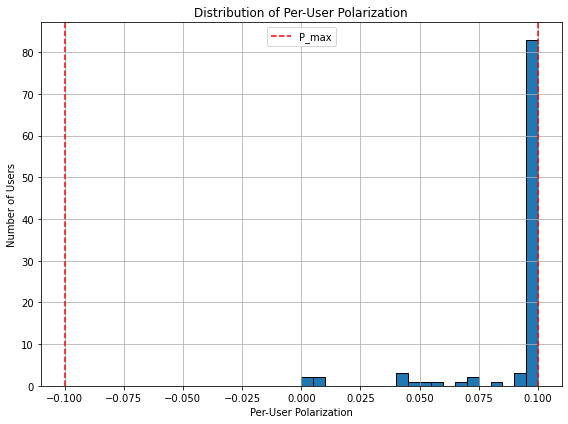

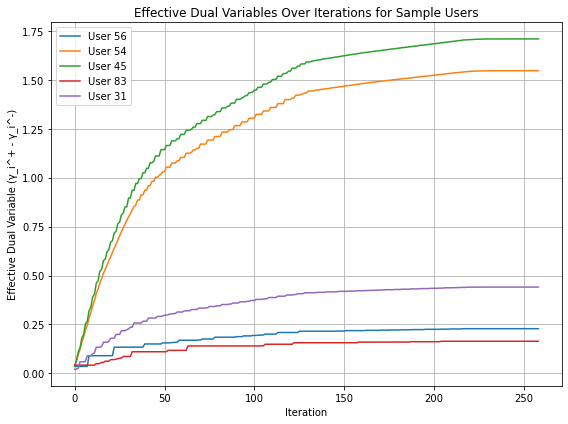

In [9]:
# Example setup
if __name__ == "__main__":
    n_users = 100  # Reduced number for demonstration
    n_content = 80
    np.random.seed(42)
    
    # Generate distributions and polarization scores
    a = np.random.rand(n_users, 1)
    a /= a.sum()
    b = np.random.rand(n_content, 1)
    b /= b.sum()
    C = np.random.rand(n_users, n_content)  # Cost matrix
    P = np.random.rand(n_content)  # Polarization scores
    
    # Constraints and regularization
    P_max = 0.1  # Adjusted per-user P_max
    epsilon = 0.1
    dual_lr = 0.1  # Learning rate for dual variables
    
    # Run the modified Sinkhorn algorithm
    Pi, results = sinkhorn_per_user_polarization(
        C, a, b, P, P_max, epsilon, dual_lr=dual_lr, precision=1e-6, max_iter=5000
    )
    
    # Print the results
    per_user_polarization = (Pi @ P) / a.flatten()
    print("Optimal transport plan computed.")
    print(f"Maximum per-user polarization: {np.max(np.abs(per_user_polarization)):.6f}")
    print(f"Per-user polarization constraints satisfied: {np.all(np.abs(per_user_polarization) <= P_max + 1e-6)}")
    print(f"Sum over users (should equal a): {np.allclose(Pi.sum(axis=1, keepdims=True), a, atol=1e-6)}")
    print(f"Sum over content (should equal b): {np.allclose(Pi.sum(axis=0, keepdims=True).T, b, atol=1e-6)}")
    
    # Plotting per-user polarization distribution
    plt.figure(figsize=(8, 6))
    plt.hist(per_user_polarization, bins=20, edgecolor='black')
    plt.axvline(P_max, color='red', linestyle='--', label='P_max')
    plt.axvline(-P_max, color='red', linestyle='--')
    plt.xlabel('Per-User Polarization')
    plt.ylabel('Number of Users')
    plt.title('Distribution of Per-User Polarization')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plotting dual variables over iterations for a sample of users
    sample_users = np.random.choice(n_users, size=5, replace=False)
    plt.figure(figsize=(8, 6))
    for i in sample_users:
        gamma_effective = [gamma_plus[i] - gamma_minus[i] for gamma_plus, gamma_minus in zip(results['gamma_plus_history'], results['gamma_minus_history'])]
        plt.plot(results['iterations'], gamma_effective, label=f'User {i}')
    plt.xlabel('Iteration')
    plt.ylabel('Effective Dual Variable (γ_i^+ - γ_i^-)')
    plt.title('Effective Dual Variables Over Iterations for Sample Users')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
